In [1]:

import os
import numpy as np
from tqdm import tqdm

from source.ConfigSettings import base_volume_unit_dim, base_voxel_size
from source.VolumeUnit import VolumeUnit
from source.AWMR_utils import pad_awmr_from_original, make_mesh, mesh_whole_block_singularize, split_into_resolution,pad_awmr_from_original, mesh_whole_block
from source.AWMRblock8x8 import AWMRblock8x8 as AWMRblock # TODO

from utils.TSDFDataset import TSDFDataset
from utils.evalUtils import customChamfer, customHausdorff, key_is_in

import open3d as o3d

import igl
import pickle
import pandas as pd

evaluate = True

dataset_name = 'soldier'
finest_voxel_size = 1.5
scale_factor = 0.002/finest_voxel_size
final_res = np.array([16,16,16])

volume_origin = np.load(f'../vunits/{dataset_name}/voxsize_{finest_voxel_size:.1f}/volume_origin_{finest_voxel_size:.1f}.npy')


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


FileNotFoundError: [Errno 2] No such file or directory: '../vunits/soldier/voxsize_1.5/volume_origin_1.5.npy'

In [1]:
p1 = np.array([166.485504 ,144.843796 ,92.823845])
p2 = np.array([185.676086 ,187.746445 ,70.507355])
vunit_start = np.floor((p1 - np.squeeze(volume_origin))/(finest_voxel_size*base_volume_unit_dim))
vunit_end = np.floor((p2 - np.squeeze(volume_origin))/(finest_voxel_size*base_volume_unit_dim))

print(vunit_start, vunit_end)

NameError: name 'np' is not defined

In [47]:
import numpy as np

# (1, 4) 입력 벡터
input_vector = np.arange(12)
print(input_vector)
# 사용자 정의 가중치를 적용한 가중 평균 계산
# result = custom_weighted_average(input_vector)

nn = np.average([input_vector[0::4],input_vector[1::4],input_vector[2::4],input_vector[3::4]],axis=0, weights=[.1,.4,.4,.1])
nn2 = np.average([input_vector[0::4],input_vector[1::4],input_vector[2::4],input_vector[3::4]],axis=0, weights=[.25,.25,.25,.25])
print(nn)
print(nn2)

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[1.5 5.5 9.5]
[1.5 5.5 9.5]


In [10]:
import numpy as np
import open3d as o3d
import torch
from pytorch3d.structures import Meshes, Pointclouds
import trimesh
import os
import sys
import pandas
from pandas import Series, DataFrame
pandas.set_option('display.float_format', '{:.7f}'.format)

####################################################################################################
dataset_name = 'armadillo'
finest_voxel_size = 0.5
split = 'awmr'
####################################################################################################
target_obj_mesh_path = f'../OriginalDataset/{dataset_name}.ply'
target_obj_mesh = trimesh.load(target_obj_mesh_path)
target_obj_verts = np.array(target_obj_mesh.vertices)
target_obj_faces = np.array(target_obj_mesh.faces)

finest_mesh_path = f'../results/[TSDF]{dataset_name}/SingleRes/voxsize_{finest_voxel_size:.6f}/{dataset_name}_singleres=[32 32 32].ply'
finest_mesh = trimesh.load(finest_mesh_path)
finest_mesh_verts = np.array(finest_mesh.vertices)
finest_mesh_faces = np.array(finest_mesh.faces)
####################################################################################################
from source.ChamferDistance import symmetric_face_to_point_distance, custom_ChamferDistance
# thres_list=[0.0005, 0.0004, 0.0003, 0.00025, 0.00022, 0.0002, 0.00018, 0.00015, 0.00012, 0.0001,
#             9e-05, 8e-05, 7e-05, 5e-05, 4e-05, 3e-05, 2e-05, 1e-05]
thres_list = [0.0001]
thres_list = [str(x) for x in thres_list] 
####################################################################################################
dist_original = []
dist_finest = []
th_list = []
print(f"[dataset: {dataset_name}] [split: {split}] [voxsize: {finest_voxel_size}]")
for thres in thres_list:
    awmr_mesh_path = f'../results/[TSDF]{dataset_name}/AWMR/voxsize_{finest_voxel_size:.6f}/{dataset_name}_{split}_thres={thres}_pool.ply'
    awmr_mesh = trimesh.load(awmr_mesh_path)
    awmr_verts = np.array(awmr_mesh.vertices)
    awmr_faces = np.array(awmr_mesh.faces)
    
    target_obj_verts = target_obj_verts.astype(np.float32)
    target_obj_faces = target_obj_faces.astype(np.int32)
    finest_mesh_verts = finest_mesh_verts.astype(np.float32)
    finest_mesh_faces = finest_mesh_faces.astype(np.int32)
    awmr_verts = awmr_verts.astype(np.float32)
    awmr_faces = awmr_faces.astype(np.int32)
    
    dist_original_A2B, dist_original_B2A = symmetric_face_to_point_distance(target_obj_verts, target_obj_faces, awmr_verts, awmr_faces)
    dist_finest_A2B, dist_finest_B2A = symmetric_face_to_point_distance(finest_mesh_verts, finest_mesh_faces, awmr_verts, awmr_faces)
    dist_original.append((dist_original_A2B+dist_original_B2A).item())
    dist_finest.append((dist_finest_A2B+dist_finest_B2A).item())
    th_list.append(thres)

raw_data = {'thres': th_list,
        'original dist': dist_original,
        'finest dist': dist_finest}
data = DataFrame(raw_data).transpose()
print(data)


[dataset: armadillo] [split: awmr] [voxsize: 0.5]
                      0
thres            0.0001
original dist 0.0038768
finest dist   0.0022825


In [14]:
import numpy as np
import open3d as o3d
import torch
from pytorch3d.structures import Meshes, Pointclouds
import trimesh
import os
import sys
import pandas
from pandas import Series, DataFrame
pandas.set_option('display.float_format', '{:.7f}'.format)

####################################################################################################
dataset_name = 'armadillo'
finest_voxel_size = 0.5
split = 'awmr'
####################################################################################################
target_obj_mesh_path = f'../OriginalDataset/{dataset_name}.ply'
target_obj_mesh = trimesh.load(target_obj_mesh_path)

finest_mesh_path = f'../results/[TSDF]{dataset_name}/SingleRes/voxsize_{finest_voxel_size:.6f}/{dataset_name}_singleres=[32 32 32].ply'
finest_mesh = trimesh.load(finest_mesh_path)

####################################################################################################
mesh_bbox = target_obj_mesh.bounding_box.extents
scale_factors = 1000.0 / mesh_bbox
target_obj_mesh.apply_scale(scale_factors)
finest_mesh.apply_scale(scale_factors)

target_obj_verts = np.array(target_obj_mesh.vertices)
target_obj_faces = np.array(target_obj_mesh.faces)
finest_mesh_verts = np.array(finest_mesh.vertices)
finest_mesh_faces = np.array(finest_mesh.faces)
####################################################################################################
from source.ChamferDistance import symmetric_face_to_point_distance, custom_ChamferDistance
# thres_list=[0.0005, 0.0004, 0.0003, 0.00025, 0.00022, 0.0002, 0.00018, 0.00015, 0.00012, 0.0001,
#             9e-05, 8e-05, 7e-05, 5e-05, 4e-05, 3e-05, 2e-05, 1e-05]
thres_list = [0.0001]
thres_list = [str(x) for x in thres_list] 
####################################################################################################
dist_original = []
dist_finest = []
th_list = []
print(f"[dataset: {dataset_name}] [split: {split}] [voxsize: {finest_voxel_size}]")
for thres in thres_list:
    awmr_mesh_path = f'../results/[TSDF]{dataset_name}/AWMR/voxsize_{finest_voxel_size:.6f}/{dataset_name}_{split}_thres={thres}_pool.ply'
    awmr_mesh = trimesh.load(awmr_mesh_path)
    awmr_mesh.apply_scale(scale_factors)
    
    awmr_verts = np.array(awmr_mesh.vertices)
    awmr_faces = np.array(awmr_mesh.faces)
    
    target_obj_verts = target_obj_verts.astype(np.float32)
    target_obj_faces = target_obj_faces.astype(np.int32)
    finest_mesh_verts = finest_mesh_verts.astype(np.float32)
    finest_mesh_faces = finest_mesh_faces.astype(np.int32)
    awmr_verts = awmr_verts.astype(np.float32)
    awmr_faces = awmr_faces.astype(np.int32)
    
    dist_original_A2B, dist_original_B2A = symmetric_face_to_point_distance(target_obj_verts, target_obj_faces, awmr_verts, awmr_faces)
    dist_finest_A2B, dist_finest_B2A = symmetric_face_to_point_distance(finest_mesh_verts, finest_mesh_faces, awmr_verts, awmr_faces)
    dist_original.append((dist_original_A2B+dist_original_B2A).item())
    dist_finest.append((dist_finest_A2B+dist_finest_B2A).item())
    th_list.append(thres)

raw_data = {'thres': th_list,
        'original dist': dist_original,
        'finest dist': dist_finest}
data = DataFrame(raw_data).transpose()
print(data)


[dataset: armadillo] [split: awmr] [voxsize: 0.5]
                      0
thres            0.0001
original dist 0.2295830
finest dist   0.1351110


In [21]:
import pandas
from pandas import Series, DataFrame
from tqdm import tqdm
pandas.set_option('display.float_format', '{:.7f}'.format)
pandas.set_option('display.max_rows', None)
dataset_name = 'dragon'
finest_voxel_size = 0.001
split = 'octree'

thres_list=[0.0005, 0.0004, 0.0003, 0.00025, 0.00022, 0.0002, 0.00018, 0.00015, 0.00012, 0.0001,
            9e-05, 8e-05, 7e-05, 5e-05, 4e-05, 3e-05, 2e-05, 1e-05]
thres_list = [str(x) for x in thres_list] 
####################################################################################################
dist_original = []
dist_finest = []
th_list = []

for thres in tqdm(thres_list):
    dist_original.append(2)
    dist_finest.append(1)
    th_list.append(0.5)

raw_data = {'thres': th_list,
        'original dist': dist_original,
        'finest dist': dist_finest}
data = DataFrame(raw_data).transpose()
print(data)
# data.to_excel(f'../results/[TSDF]{dataset_name}/{split}/voxsize_{finest_voxel_size:.6f}/RD_{dataset_name}_{split}.xlsx', index=False)  # 파일 이름을 원하는 대로 수정할 수 있습니다.

100%|██████████| 18/18 [00:00<00:00, 18048.64it/s]

                     0         1         2         3         4         5   \
thres         0.5000000 0.5000000 0.5000000 0.5000000 0.5000000 0.5000000   
original dist 2.0000000 2.0000000 2.0000000 2.0000000 2.0000000 2.0000000   
finest dist   1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000   

                     6         7         8         9         10        11  \
thres         0.5000000 0.5000000 0.5000000 0.5000000 0.5000000 0.5000000   
original dist 2.0000000 2.0000000 2.0000000 2.0000000 2.0000000 2.0000000   
finest dist   1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000   

                     12        13        14        15        16        17  
thres         0.5000000 0.5000000 0.5000000 0.5000000 0.5000000 0.5000000  
original dist 2.0000000 2.0000000 2.0000000 2.0000000 2.0000000 2.0000000  
finest dist   1.0000000 1.0000000 1.0000000 1.0000000 1.0000000 1.0000000  


In [111]:
import open3d as o3d

# 원래 메쉬를 로드합니다.
ori_mesh_path = '../results/[TSDF]dragon/awmr/voxsize_0.001000/dragon_awmr_thres=0.318.ply'
ori_mesh = o3d.io.read_triangle_mesh(ori_mesh_path)
ori_mesh = o3d.t.geometry.TriangleMesh.from_legacy(ori_mesh)

# degenerate 삼각형을 제거합니다.
# ori_mesh.remove_degenerate_triangles()

# 구멍을 채웁니다.
filled_mesh = ori_mesh.fill_holes()
ori_mesh.shape
# o3d.visualization.draw_geometries([ori_mesh])
# # 저장할 때 포맷을 지정합니다. PLY 포맷을 사용하려면 'ply'로 지정합니다.
# output_mesh_path = '../results/[TSDF]dragon/awmr/voxsize_0.001000/filled_dragon.ply'
# o3d.io.write_triangle_mesh(output_mesh_path, filled_mesh, write_ascii=True)  # 또는 write_ascii=False


AttributeError: 'open3d.cpu.pybind.t.geometry.TriangleMesh' object has no attribute 'shape'

[8.00000000e-08 1.00714033e-07 1.26791455e-07 1.59620985e-07
 2.00950915e-07 2.52982213e-07 3.18485736e-07 4.00949787e-07
 5.04765876e-07 6.35462588e-07 8.00000000e-07 1.00714033e-06
 1.26791455e-06 1.59620985e-06 2.00950915e-06]


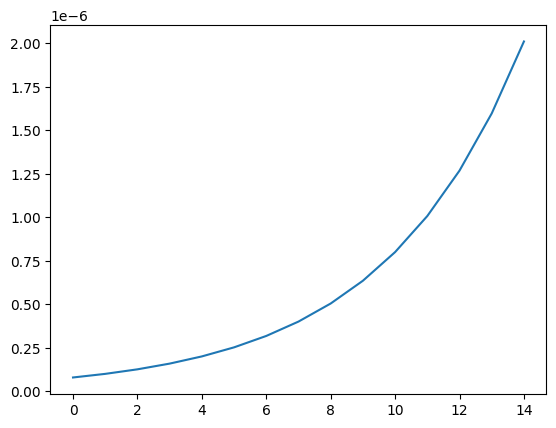

In [67]:
import numpy as np

x = np.logspace(0, 1.4, 15) * 8e-8
y = [str(x) for x in x]
print(x)
import matplotlib.pyplot as plt
plt.plot(x)

In [89]:
thres_list = np.logspace(0, 1.4, 15) * 8e-8
thres_str = [str(round(x*1e6,3)) for x in thres_list]

# y = round(x[1]*1e10, 3)
print(thres_str)

['0.08', '0.101', '0.127', '0.16', '0.201', '0.253', '0.318', '0.401', '0.505', '0.635', '0.8', '1.007', '1.268', '1.596', '2.01']


In [123]:
import trimesh
ori_mesh_path = '../results/[TSDF]dragon/awmr/voxsize_0.001000/iftrue/dragon_awmr_thres=0.08.ply'
ori_mesh = trimesh.load(ori_mesh_path)


In [124]:
trimesh.repair.fill_holes(ori_mesh)
ori_mesh.export(ori_mesh_path + '_filled')

ValueError: ('%s exporter not available!', 'ply_filled')


[비교하려는 대상 메시]: filled_dragon.ply
[원본 obj 파일과의 distance]: 1.3705108165740967
[finest mesh 파일과의 distance]: 0.348558247089386
